In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('solar_panels.csv')

In [3]:
df['date'] = df['date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))

In [4]:
test_date = datetime(2020,1,1)
start_date = datetime(2012, 1, 1)
df = df[(start_date <= df["date"])]


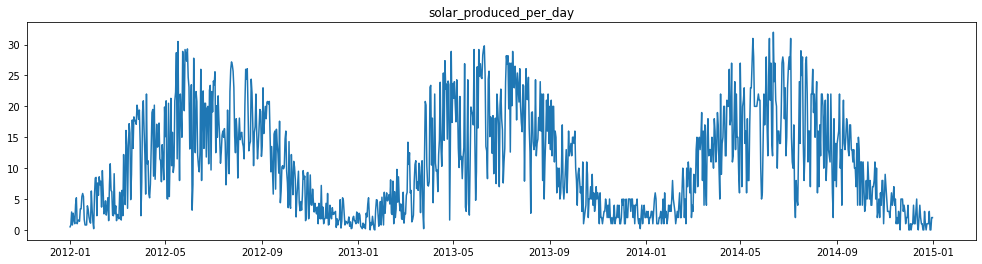

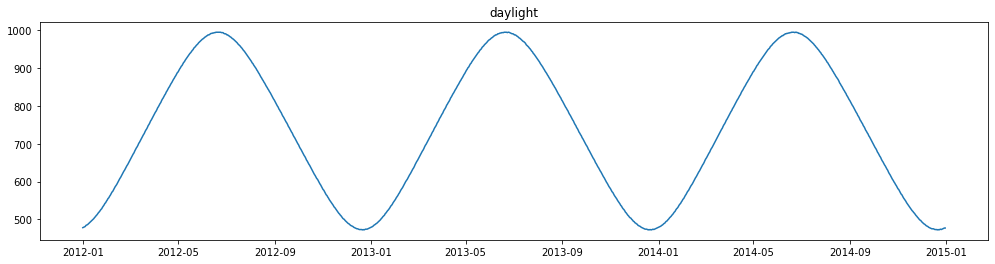

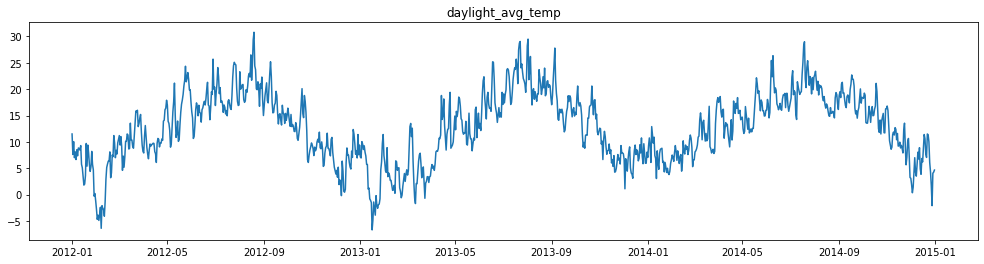

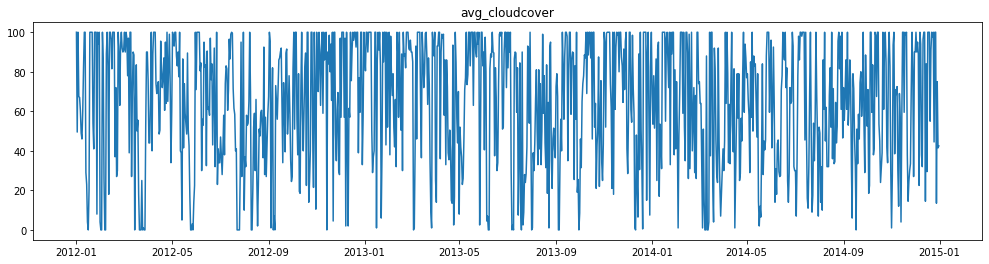

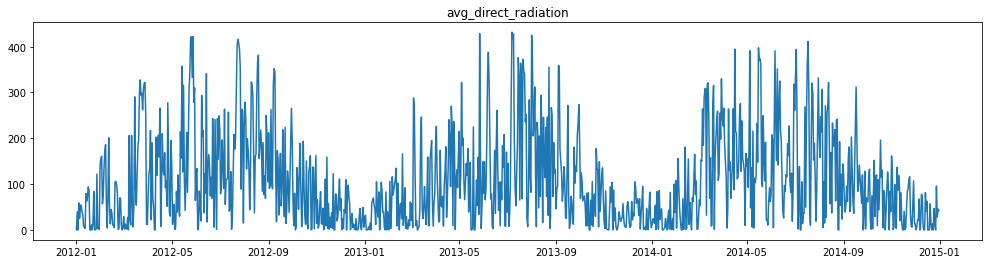

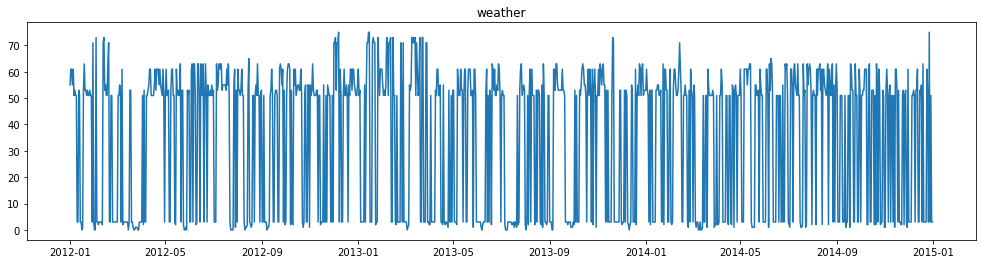

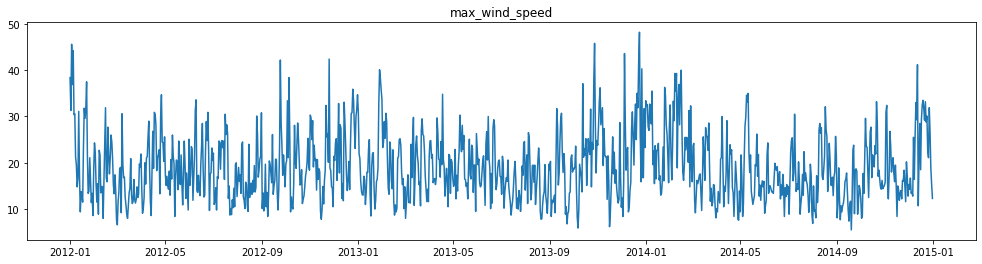

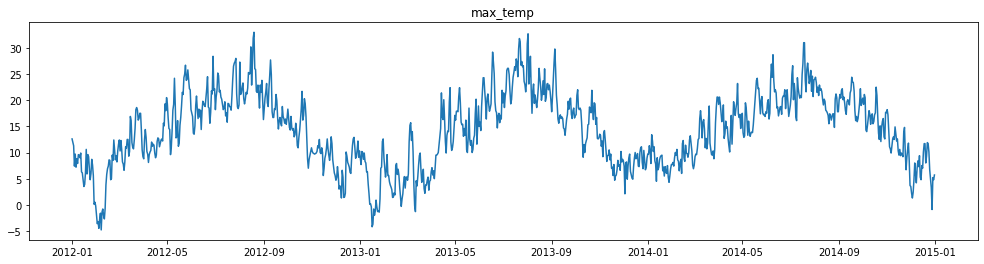

In [5]:
# solar_produced_per_day
stop_date = datetime(2015, 1, 1)
columns = list(df.columns)
columns.remove('date')

plot_year= df[(df['date'] < stop_date)]
for column in columns:
    
    plt.figure().set_figwidth(17)
    plt.title(column)
    plt.plot(plot_year['date'].to_numpy(),plot_year[column].to_numpy())
    plt.show()

We can clearly see seasonality here, so we need to preprocess the data so it's stationary. Stationarity is important for auto regressive models.

#### Normalization

In [6]:
used_columns = ['solar_produced_per_day',
                'daylight_avg_temp', 'avg_cloudcover', 
                'avg_direct_radiation', 'max_wind_speed']

df = df[['date',*used_columns]]

used_cols_params = {}

for col in used_columns:
    mu = df[col].mean()
    sigma = df[col].std()
    df[col] = df[col].apply(lambda x: (x-mu)/sigma)
    used_cols_params[col] = {
        'sigma': sigma,
        'mu': mu
    }

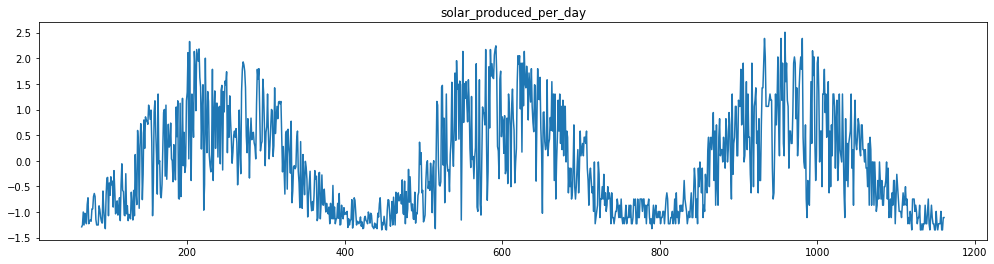

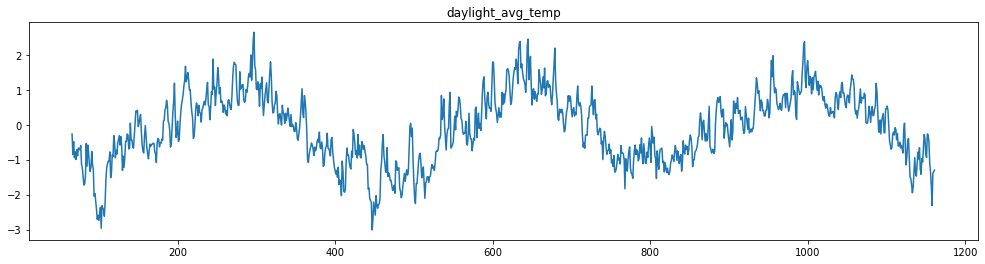

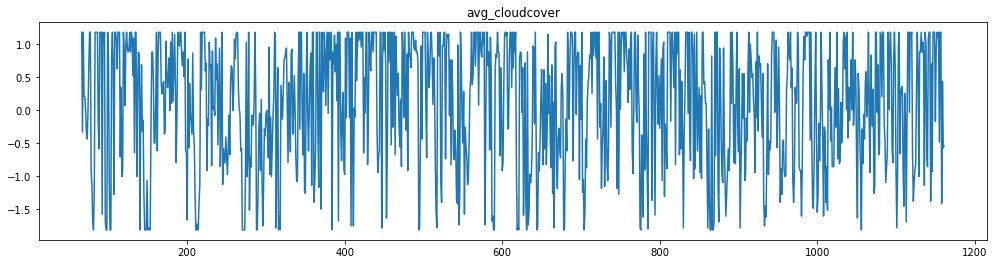

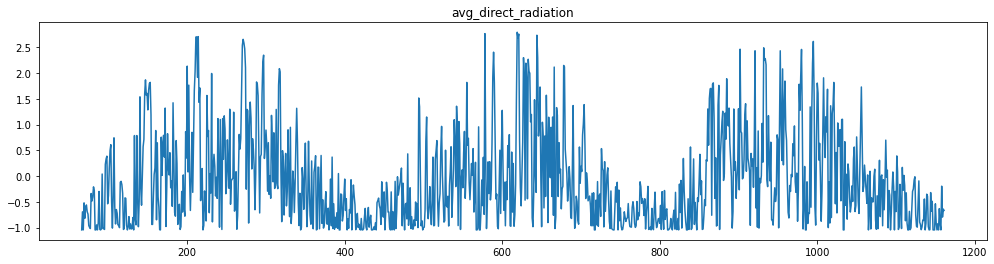

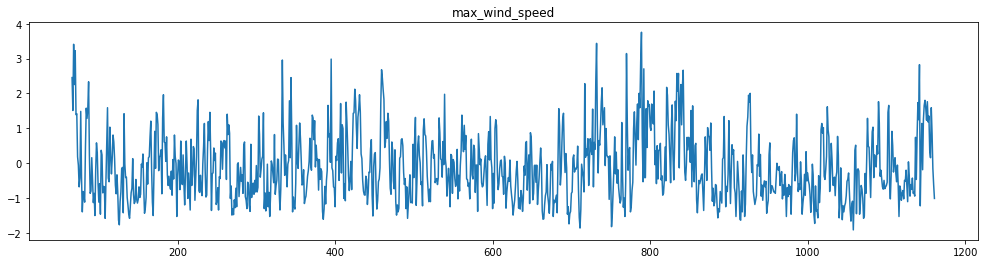

In [7]:
plot_year= df[(df['date'] < stop_date)]
for column in used_columns:
    
    plt.figure().set_figwidth(17)
    plt.title(column)
    plt.plot(plot_year.index.to_numpy(),plot_year[column].to_numpy())
    plt.show()

#### Remove High Volatility

In [8]:
days_in_months_stds = df.groupby(df["date"].dt.strftime('%m')).std()

for col in used_columns:
    stds = df['date'].apply(lambda date: days_in_months_stds[col].loc[date.strftime('%m')])
    df[col] = df[col]/ stds

#### Remove Seasonality

In [9]:
days_in_months_averages = df.groupby(df["date"].dt.strftime('%m')).mean()

for col in used_columns:
    mean_col_month_day = df['date'].apply(lambda date: days_in_months_averages[col].loc[date.strftime('%m')])
    df[col] = df[col]-mean_col_month_day

#### Augemented Dickey-Fuller Test
To check if time series are stationary

In [10]:
from statsmodels.tsa.stattools import adfuller

for col in used_columns:
    test = adfuller(df[col])
    print(f"Column: {col}, ADF VAL: {test[0]}, P-value: {test[1]}")

Column: solar_produced_per_day, ADF VAL: -25.105868167681965, P-value: 0.0
Column: daylight_avg_temp, ADF VAL: -19.16125978353387, P-value: 0.0
Column: avg_cloudcover, ADF VAL: -20.226061534632116, P-value: 0.0
Column: avg_direct_radiation, ADF VAL: -25.6295181349609, P-value: 0.0
Column: max_wind_speed, ADF VAL: -23.853347535185154, P-value: 0.0


Based on P-values less than .05 we can conclude that time series are stationary now.

Since we want to use multiple features to predict production of solar panels, VAR model should be appropiate.

#### PACF

C:\Users\Hubert\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


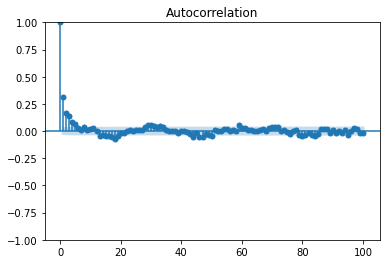

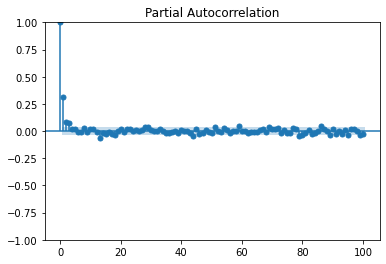

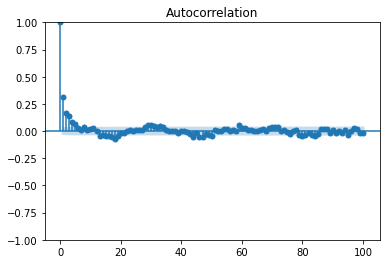

In [11]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
pacf_plot = plot_pacf(df['solar_produced_per_day'], lags=100,)
plot_acf(df['solar_produced_per_day'], lags=100)


In [12]:
from scipy.stats import pearsonr

test_df  = df.loc[(df["date"] >= test_date)]
train_df  = df.loc[(start_date <= df["date"])&(df["date"] < test_date)]
train_df.set_index('date', inplace=True)
train_df = train_df.asfreq(pd.infer_freq(train_df.index))

for col in used_columns:
    if col == 'solar_produced_per_day':
        continue
    
    print(col)
    for lag in range(1, 20):
        solar_series = train_df['solar_produced_per_day'].iloc[lag:]
        lagged_col = train_df[col].iloc[:-lag]
        
        print(f"Lag: {lag}, Correlation: {pearsonr(solar_series, lagged_col)}")
    print()
        
    


daylight_avg_temp
Lag: 1, Correlation: (0.19982288372884252, 1.0883182401645207e-27)
Lag: 2, Correlation: (0.10942320412216996, 3.0630933817713595e-09)
Lag: 3, Correlation: (0.0794693335356745, 1.7194909292225925e-05)
Lag: 4, Correlation: (0.038305807391827984, 0.0385371141221849)
Lag: 5, Correlation: (0.022257158160567024, 0.22946961259638776)
Lag: 6, Correlation: (-0.0005465713047664296, 0.9764640659126642)
Lag: 7, Correlation: (0.005769240994390953, 0.7555310753875168)
Lag: 8, Correlation: (-0.01865252999672782, 0.31415265973549844)
Lag: 9, Correlation: (-0.012914118238416018, 0.48596960994582933)
Lag: 10, Correlation: (-0.017978653094877974, 0.3321247541950886)
Lag: 11, Correlation: (-0.02171289141078748, 0.2415483799654668)
Lag: 12, Correlation: (-0.011496386891814214, 0.5353105150997406)
Lag: 13, Correlation: (-0.012267461537226517, 0.5083636155479601)
Lag: 14, Correlation: (-0.006621120410961741, 0.7211665828276645)
Lag: 15, Correlation: (-0.00174625104524413, 0.9250205838192298

#### VAR model

In [13]:
test_df.set_index('date', inplace=True)

In [14]:
df.set_index('date', inplace=True)
df = df.asfreq(pd.infer_freq(df.index))

### Rolling Forecast Origin

In [15]:
from statsmodels.tsa.api import VAR
from datetime import timedelta

rolling_predictions = test_df.copy()

for train_end in test_df.index:
    train_data = df[:train_end-timedelta(days=1)]
    model = VAR(train_df)
    results = model.fit(maxlags=5)
    pred = results.forecast(train_data.values[-results.k_ar:], 1)[:, 0]
    rolling_predictions.loc[train_end, 'solar_produced_per_day'] = pred


<AxesSubplot:xlabel='date'>

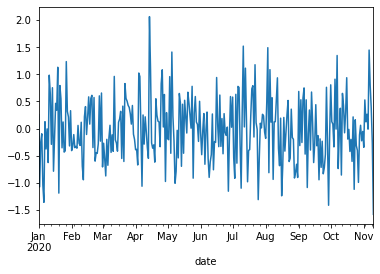

In [16]:
rolling_residuals = test_df['solar_produced_per_day'] - rolling_predictions['solar_produced_per_day']
rolling_residuals.plot()

The rolling residuals look like the mean is constant and close to zero, the standard deviation also looks close to constant. Based on this, we can say that the model did a good job because the residuals are close to white noise.

MAE: 0.47839985106689326


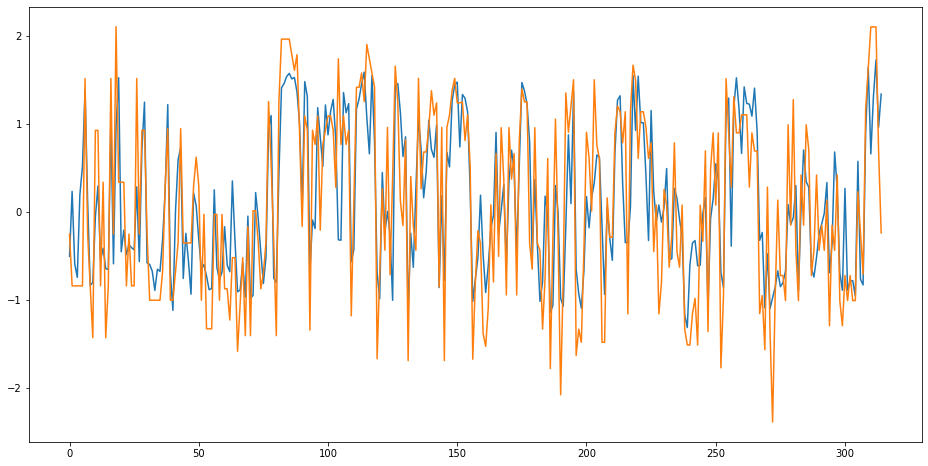

In [17]:
plt.figure(figsize=(16,8))
plt.plot(rolling_predictions['solar_produced_per_day'].values)
plt.plot(test_df['solar_produced_per_day'].values)
print(f"MAE: {np.mean(abs(rolling_residuals))}")

The MAE above doesn't relate directly to original predictions. We need to transform our predictions back.

### Revert back to original form

$$
\hat{original_{t}} = ((\hat{transformed_{t}} + \mu) \cdot \sigma \cdot month_{std}) + month_{mean}
$$

In [18]:
def convert_to_original(data):
    #revert back seasonality
    month_mean = data['date'].apply(lambda date: days_in_months_averages['solar_produced_per_day'].loc[date.strftime('%m')])
    data['solar_produced_per_day'] = data['solar_produced_per_day'] + month_mean
    
    
    #revert back high Volatility
    std_month = data['date'].apply(lambda date: days_in_months_stds['solar_produced_per_day'].loc[date.strftime('%m')])
    data['solar_produced_per_day'] = data['solar_produced_per_day'] * std_month  
    
    #revert back  normalization
    mu = used_cols_params['solar_produced_per_day']['mu']
    sigma = used_cols_params['solar_produced_per_day']['sigma']
    data['solar_produced_per_day'] = data['solar_produced_per_day'].apply(lambda t: (t*sigma)+mu)
    
    

predictions = rolling_predictions['solar_produced_per_day'].to_frame('solar_produced_per_day').reset_index()
target = test_df['solar_produced_per_day'].to_frame('solar_produced_per_day').reset_index()
convert_to_original(predictions)
convert_to_original(target)

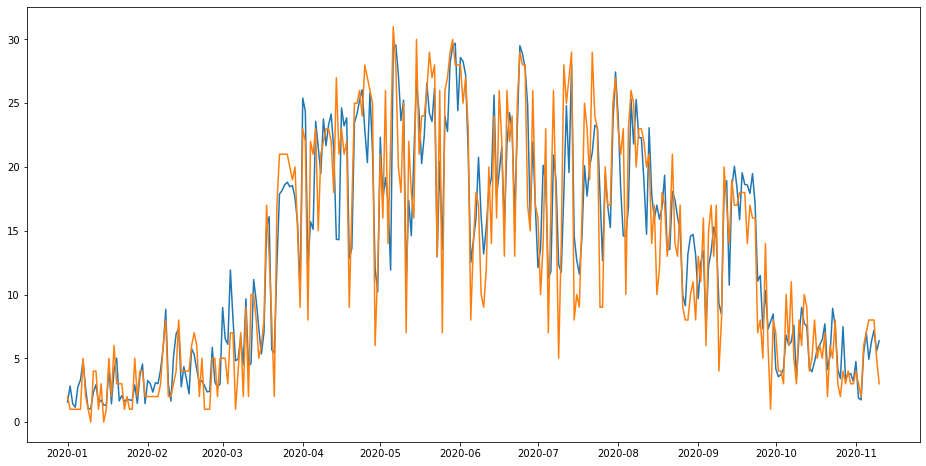

In [19]:
plt.figure(figsize=(16,8))
plt.plot(predictions['date'],predictions['solar_produced_per_day'])
plt.plot(target['date'],target['solar_produced_per_day'])

In [20]:
error = predictions['solar_produced_per_day'].values - target['solar_produced_per_day'].values
print(f"FINAL MAE: {np.mean(abs(error))}")

FINAL MAE: 2.3974638326313227
